In [3]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt




# Cruide Oil WTI 

## 7:3

In [4]:
df= pd.read_csv('../dataset/Crude Oil WTI.csv')

In [5]:
keras.utils.set_random_seed(42)

### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [6]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [7]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,55.8,57.22,57.88,55.57,684190.0,-2.48
1,2019-03-02 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
2,2019-03-03 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
3,2019-03-04 00:00:00,56.59,55.83,57.0,55.81,549400.0,1.42
4,2019-03-05 00:00:00,56.56,56.45,57.19,56.09,538400.0,-0.05
...,...,...,...,...,...,...,...
1787,2024-05-24 00:00:00,77.72,77.04,78.05,76.15,299080.0,1.11
1788,2024-05-28 00:00:00,79.83,77.81,80.29,77.69,334070.0,1.5
1789,2024-05-29 00:00:00,79.23,80.26,80.62,78.99,259589.0,-0.75
1790,2024-05-30 00:00:00,77.91,79.28,79.42,77.63,373780.0,-1.67


In [8]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,55.8,57.22,57.88,55.57,684190.0,-2.48
1,2019-03-02 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
2,2019-03-03 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
3,2019-03-04 00:00:00,56.59,55.83,57.0,55.81,549400.0,1.42
4,2019-03-05 00:00:00,56.56,56.45,57.19,56.09,538400.0,-0.05
...,...,...,...,...,...,...,...
1787,2024-05-24 00:00:00,77.72,77.04,78.05,76.15,299080.0,1.11
1788,2024-05-28 00:00:00,79.83,77.81,80.29,77.69,334070.0,1.5
1789,2024-05-29 00:00:00,79.23,80.26,80.62,78.99,259589.0,-0.75
1790,2024-05-30 00:00:00,77.91,79.28,79.42,77.63,373780.0,-1.67


### Train, Test


In [9]:
# Split the data into training, testing sets
price = df['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Tạo và huấn luyện mô hình

In [10]:
X_train.shape

(1234, 20, 1)

In [11]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64)

c:\Users\21521\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2016
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013    
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012    
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011    
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010    
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010    
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8424e-04
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7439e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6954e-04
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6988e-04
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5030e-04
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5328e-04
Epoch 15/100
20/20 ━━━━━━━━

In [12]:
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [13]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 2.936237543055683
MAPE trên tập test là: 2.980064387248792 %
MDA trên tập test là: 40.50387596899225 %


In [14]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-20:]
next_90_days = []
for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print(next_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [15]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)
next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1792,78.674324
1793,78.488907
1794,78.152679
1795,77.898003
1796,77.853958
...,...
1877,75.046181
1878,75.006126
1879,74.965965
1880,74.925774


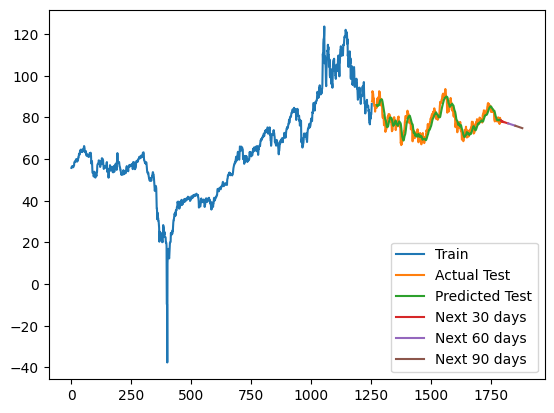

In [16]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()

## 8:2

In [17]:
df= pd.read_csv('../dataset/Crude Oil WTI.csv')

In [18]:
keras.utils.set_random_seed(42)

### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [19]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [20]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,55.8,57.22,57.88,55.57,684190.0,-2.48
1,2019-03-02 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
2,2019-03-03 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
3,2019-03-04 00:00:00,56.59,55.83,57.0,55.81,549400.0,1.42
4,2019-03-05 00:00:00,56.56,56.45,57.19,56.09,538400.0,-0.05
...,...,...,...,...,...,...,...
1787,2024-05-24 00:00:00,77.72,77.04,78.05,76.15,299080.0,1.11
1788,2024-05-28 00:00:00,79.83,77.81,80.29,77.69,334070.0,1.5
1789,2024-05-29 00:00:00,79.23,80.26,80.62,78.99,259589.0,-0.75
1790,2024-05-30 00:00:00,77.91,79.28,79.42,77.63,373780.0,-1.67


In [21]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,55.8,57.22,57.88,55.57,684190.0,-2.48
1,2019-03-02 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
2,2019-03-03 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
3,2019-03-04 00:00:00,56.59,55.83,57.0,55.81,549400.0,1.42
4,2019-03-05 00:00:00,56.56,56.45,57.19,56.09,538400.0,-0.05
...,...,...,...,...,...,...,...
1787,2024-05-24 00:00:00,77.72,77.04,78.05,76.15,299080.0,1.11
1788,2024-05-28 00:00:00,79.83,77.81,80.29,77.69,334070.0,1.5
1789,2024-05-29 00:00:00,79.23,80.26,80.62,78.99,259589.0,-0.75
1790,2024-05-30 00:00:00,77.91,79.28,79.42,77.63,373780.0,-1.67


### Train, Test


In [22]:
# Split the data into training, testing, and validation sets
price = df['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Tạo và huấn luyện mô hình

In [23]:
X_train.shape

(1413, 20, 1)

In [24]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64)

Epoch 1/100


c:\Users\21521\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1950  
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013    
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011    
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011    
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010    
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9444e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8496e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9055e-04
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7762e-04
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7619e-04
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7345e-04
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6703e-04
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━

In [25]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [26]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 1.95621615007193
MAPE trên tập test là: 1.970786289025824 %
MDA trên tập test là: 43.62017804154303 %


In [27]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-20:]
next_90_days = []
for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print(next_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━

In [28]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)
next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1792,77.649361
1793,76.578133
1794,75.949570
1795,75.662323
1796,75.703506
...,...
1877,66.584274
1878,66.502373
1879,66.410324
1880,66.307396


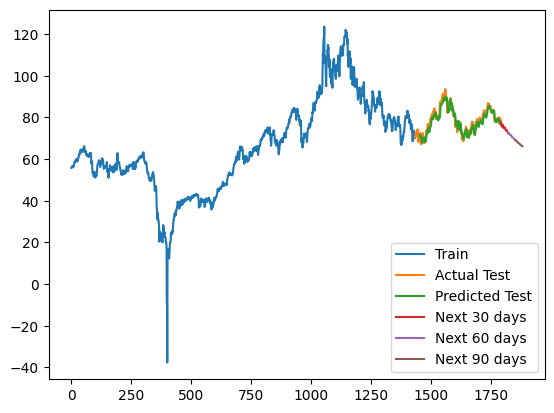

In [29]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()

## 9:1

In [30]:
df= pd.read_csv('../dataset/Crude Oil WTI.csv')

In [31]:
keras.utils.set_random_seed(42)

### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [32]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [33]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,55.8,57.22,57.88,55.57,684190.0,-2.48
1,2019-03-02 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
2,2019-03-03 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
3,2019-03-04 00:00:00,56.59,55.83,57.0,55.81,549400.0,1.42
4,2019-03-05 00:00:00,56.56,56.45,57.19,56.09,538400.0,-0.05
...,...,...,...,...,...,...,...
1787,2024-05-24 00:00:00,77.72,77.04,78.05,76.15,299080.0,1.11
1788,2024-05-28 00:00:00,79.83,77.81,80.29,77.69,334070.0,1.5
1789,2024-05-29 00:00:00,79.23,80.26,80.62,78.99,259589.0,-0.75
1790,2024-05-30 00:00:00,77.91,79.28,79.42,77.63,373780.0,-1.67


In [34]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,55.8,57.22,57.88,55.57,684190.0,-2.48
1,2019-03-02 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
2,2019-03-03 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
3,2019-03-04 00:00:00,56.59,55.83,57.0,55.81,549400.0,1.42
4,2019-03-05 00:00:00,56.56,56.45,57.19,56.09,538400.0,-0.05
...,...,...,...,...,...,...,...
1787,2024-05-24 00:00:00,77.72,77.04,78.05,76.15,299080.0,1.11
1788,2024-05-28 00:00:00,79.83,77.81,80.29,77.69,334070.0,1.5
1789,2024-05-29 00:00:00,79.23,80.26,80.62,78.99,259589.0,-0.75
1790,2024-05-30 00:00:00,77.91,79.28,79.42,77.63,373780.0,-1.67


### Train, Test


In [35]:
# Split the data into training, testing, and validation sets
price = df['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Tạo và huấn luyện mô hình

In [36]:
X_train.shape

(1592, 20, 1)

In [37]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64)

Epoch 1/100


c:\Users\21521\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2328  
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012    
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010    
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5186e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0743e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8759e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6929e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5113e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2785e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1769e-04
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2101e-04
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1306e-04
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1696e-04
Epoch 15/100
25/25 ━━━━━━━━━━━━━━

In [38]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [39]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 1.642704468239148
MAPE trên tập test là: 1.6296488622419614 %
MDA trên tập test là: 43.037974683544306 %


In [40]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-20:]
next_90_days = []
for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print(next_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━

In [41]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)
next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1792,78.587021
1793,77.867119
1794,77.110985
1795,76.811668
1796,76.976379
...,...
1877,74.335106
1878,74.301720
1879,74.270142
1880,74.239044


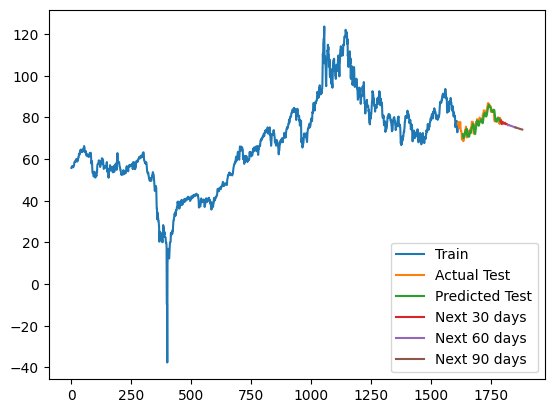

In [42]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()

# Gasoline RBOB

## 7:3

In [43]:
df= pd.read_csv('../dataset/Gasoline RBOB.csv')

In [44]:
keras.utils.set_random_seed(42)

### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [45]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



C:\Users\21521\AppData\Local\Temp\ipykernel_17020\293547747.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weekend_data.loc[len(weekend_data)] = new_row


In [46]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,1.5356,1.7521,1.772,1.7124,69010.0,-1.37
1,2019-03-04 00:00:00,1.553,1.7285,1.766,1.7285,62550.0,-10.41
2,2019-03-05 00:00:00,1.5601,1.7474,1.7735,1.7387,61430.0,0.46
3,2019-03-06 00:00:00,1.5674,1.7604,1.7919,1.7524,91540.0,0.47
4,2019-03-07 00:00:00,1.5743,1.7845,1.816,1.7845,78590.0,0.44
...,...,...,...,...,...,...,...
1340,2024-05-27 00:00:00,2.514,2.502,2.5154,2.502,20.0,1.53
1341,2024-05-28 00:00:00,2.509,2.5151,2.5244,2.5022,330.0,-0.2
1342,2024-05-29 00:00:00,2.4644,2.5208,2.5304,2.4579,1280.0,-1.78
1343,2024-05-30 00:00:00,2.4046,2.456,2.4613,2.4295,440.0,-2.43


In [47]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,1.5356,1.7521,1.772,1.7124,69010.0,-1.37
1,2019-03-04 00:00:00,1.553,1.7285,1.766,1.7285,62550.0,-10.41
2,2019-03-05 00:00:00,1.5601,1.7474,1.7735,1.7387,61430.0,0.46
3,2019-03-06 00:00:00,1.5674,1.7604,1.7919,1.7524,91540.0,0.47
4,2019-03-07 00:00:00,1.5743,1.7845,1.816,1.7845,78590.0,0.44
...,...,...,...,...,...,...,...
1340,2024-05-27 00:00:00,2.514,2.502,2.5154,2.502,20.0,1.53
1341,2024-05-28 00:00:00,2.509,2.5151,2.5244,2.5022,330.0,-0.2
1342,2024-05-29 00:00:00,2.4644,2.5208,2.5304,2.4579,1280.0,-1.78
1343,2024-05-30 00:00:00,2.4046,2.456,2.4613,2.4295,440.0,-2.43


### Train, Test


In [48]:
# Split the data into training, testing, and validation sets
price = df['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Tạo và huấn luyện mô hình

In [49]:
X_train.shape

(921, 20, 1)

In [50]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64)

Epoch 1/100


c:\Users\21521\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0659  
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011    
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011     
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011    
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011    
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011     
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011    
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011     
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011     
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010     
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8693e-04
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━

In [51]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [52]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 0.10155084927260277
MAPE trên tập test là: 3.2670454855031386 %
MDA trên tập test là: 44.24083769633508 %


In [53]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-20:]
next_90_days = []
for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print(next_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━

In [54]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)
next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1345,2.489419
1346,2.482272
1347,2.501450
1348,2.534807
1349,2.567098
...,...
1430,3.061709
1431,3.067262
1432,3.072963
1433,3.078631


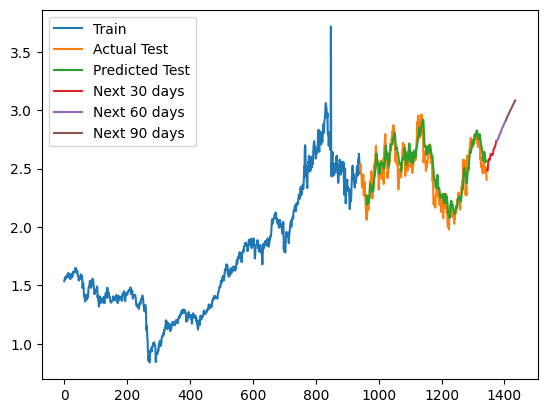

In [55]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()

## 8:2

In [56]:
df= pd.read_csv('../dataset/Gasoline RBOB.csv')

In [57]:
keras.utils.set_random_seed(42)

### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [58]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



C:\Users\21521\AppData\Local\Temp\ipykernel_17020\293547747.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weekend_data.loc[len(weekend_data)] = new_row


In [59]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,1.5356,1.7521,1.772,1.7124,69010.0,-1.37
1,2019-03-04 00:00:00,1.553,1.7285,1.766,1.7285,62550.0,-10.41
2,2019-03-05 00:00:00,1.5601,1.7474,1.7735,1.7387,61430.0,0.46
3,2019-03-06 00:00:00,1.5674,1.7604,1.7919,1.7524,91540.0,0.47
4,2019-03-07 00:00:00,1.5743,1.7845,1.816,1.7845,78590.0,0.44
...,...,...,...,...,...,...,...
1340,2024-05-27 00:00:00,2.514,2.502,2.5154,2.502,20.0,1.53
1341,2024-05-28 00:00:00,2.509,2.5151,2.5244,2.5022,330.0,-0.2
1342,2024-05-29 00:00:00,2.4644,2.5208,2.5304,2.4579,1280.0,-1.78
1343,2024-05-30 00:00:00,2.4046,2.456,2.4613,2.4295,440.0,-2.43


In [60]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,1.5356,1.7521,1.772,1.7124,69010.0,-1.37
1,2019-03-04 00:00:00,1.553,1.7285,1.766,1.7285,62550.0,-10.41
2,2019-03-05 00:00:00,1.5601,1.7474,1.7735,1.7387,61430.0,0.46
3,2019-03-06 00:00:00,1.5674,1.7604,1.7919,1.7524,91540.0,0.47
4,2019-03-07 00:00:00,1.5743,1.7845,1.816,1.7845,78590.0,0.44
...,...,...,...,...,...,...,...
1340,2024-05-27 00:00:00,2.514,2.502,2.5154,2.502,20.0,1.53
1341,2024-05-28 00:00:00,2.509,2.5151,2.5244,2.5022,330.0,-0.2
1342,2024-05-29 00:00:00,2.4644,2.5208,2.5304,2.4579,1280.0,-1.78
1343,2024-05-30 00:00:00,2.4046,2.456,2.4613,2.4295,440.0,-2.43


### Train, Test


In [61]:
# Split the data into training, testing, and validation sets
price = df['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Tạo và huấn luyện mô hình

In [62]:
X_train.shape

(1056, 20, 1)

In [63]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64)

c:\Users\21521\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0812  
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014    
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013    
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013    
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013    
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013   
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012    
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012    
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012    
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011    
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011    
Epoch 15/100
17/17 ━━━━━━━━━━━

In [64]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [65]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 0.07827281756616271
MAPE trên tập test là: 2.447487902255806 %
MDA trên tập test là: 49.596774193548384 %


In [66]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-20:]
next_90_days = []
for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print(next_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━

In [67]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)
next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1345,2.431852
1346,2.427560
1347,2.432679
1348,2.453871
1349,2.474980
...,...
1430,2.599048
1431,2.600054
1432,2.601090
1433,2.602001


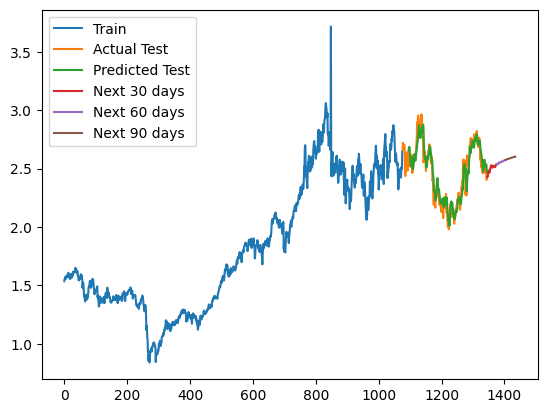

In [68]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()

## 9:1

In [69]:
df= pd.read_csv('../dataset/Gasoline RBOB.csv')

In [70]:
keras.utils.set_random_seed(42)

### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [71]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



C:\Users\21521\AppData\Local\Temp\ipykernel_17020\293547747.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weekend_data.loc[len(weekend_data)] = new_row


In [72]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,1.5356,1.7521,1.772,1.7124,69010.0,-1.37
1,2019-03-04 00:00:00,1.553,1.7285,1.766,1.7285,62550.0,-10.41
2,2019-03-05 00:00:00,1.5601,1.7474,1.7735,1.7387,61430.0,0.46
3,2019-03-06 00:00:00,1.5674,1.7604,1.7919,1.7524,91540.0,0.47
4,2019-03-07 00:00:00,1.5743,1.7845,1.816,1.7845,78590.0,0.44
...,...,...,...,...,...,...,...
1340,2024-05-27 00:00:00,2.514,2.502,2.5154,2.502,20.0,1.53
1341,2024-05-28 00:00:00,2.509,2.5151,2.5244,2.5022,330.0,-0.2
1342,2024-05-29 00:00:00,2.4644,2.5208,2.5304,2.4579,1280.0,-1.78
1343,2024-05-30 00:00:00,2.4046,2.456,2.4613,2.4295,440.0,-2.43


In [73]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,1.5356,1.7521,1.772,1.7124,69010.0,-1.37
1,2019-03-04 00:00:00,1.553,1.7285,1.766,1.7285,62550.0,-10.41
2,2019-03-05 00:00:00,1.5601,1.7474,1.7735,1.7387,61430.0,0.46
3,2019-03-06 00:00:00,1.5674,1.7604,1.7919,1.7524,91540.0,0.47
4,2019-03-07 00:00:00,1.5743,1.7845,1.816,1.7845,78590.0,0.44
...,...,...,...,...,...,...,...
1340,2024-05-27 00:00:00,2.514,2.502,2.5154,2.502,20.0,1.53
1341,2024-05-28 00:00:00,2.509,2.5151,2.5244,2.5022,330.0,-0.2
1342,2024-05-29 00:00:00,2.4644,2.5208,2.5304,2.4579,1280.0,-1.78
1343,2024-05-30 00:00:00,2.4046,2.456,2.4613,2.4295,440.0,-2.43


### Train, Test


In [74]:
# Split the data into training, testing, and validation sets
price = df['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Tạo và huấn luyện mô hình

In [75]:
X_train.shape

(1190, 20, 1)

In [76]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64)

Epoch 1/100


c:\Users\21521\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0797
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 16/100
19/

In [77]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [78]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 0.0732099404845724
MAPE trên tập test là: 2.1855545222609307 %
MDA trên tập test là: 48.67256637168141 %


In [79]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-20:]
next_90_days = []
for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print(next_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━

In [80]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)
next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1345,2.437683
1346,2.446794
1347,2.465423
1348,2.498891
1349,2.526151
...,...
1430,2.837886
1431,2.838982
1432,2.839485
1433,2.839694


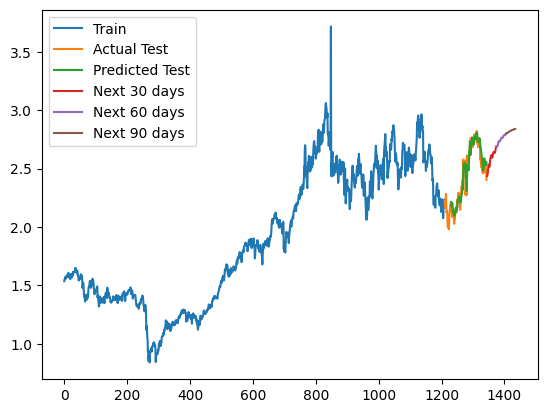

In [81]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()

# Heating Oil

## 7:3

In [82]:
df= pd.read_csv('../dataset/Heating Oil.csv')

In [83]:
keras.utils.set_random_seed(42)

### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [84]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [85]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010.0,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050.0,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160.0,0.1
...,...,...,...,...,...,...,...
1818,2024-05-24 00:00:00,2.4136,2.4175,2.4302,2.3897,21870.0,0.07
1819,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960.0,0.57
1820,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870.0,-1.14
1821,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120.0,-2.77


In [86]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010.0,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050.0,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160.0,0.1
...,...,...,...,...,...,...,...
1818,2024-05-24 00:00:00,2.4136,2.4175,2.4302,2.3897,21870.0,0.07
1819,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960.0,0.57
1820,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870.0,-1.14
1821,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120.0,-2.77


### Train, Test


In [87]:
# Split the data into training, testing, and validation sets
price = df['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Tạo và huấn luyện mô hình

In [88]:
X_train.shape

(1256, 20, 1)

In [89]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64)

Epoch 1/100


c:\Users\21521\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1127
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016    
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015    
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015    
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015    
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015    
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014    
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014    
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - l

In [90]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [91]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 0.139565949167094
MAPE trên tập test là: 4.081431232034244 %
MDA trên tập test là: 44.57142857142857 %


In [92]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-20:]
next_90_days = []
for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print(next_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [93]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)
next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1823,2.422171
1824,2.405256
1825,2.426402
1826,2.453448
1827,2.488182
...,...
1908,4.601374
1909,4.606545
1910,4.614268
1911,4.625002


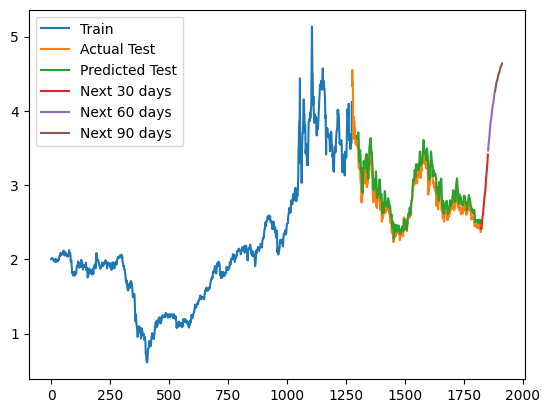

In [94]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()

## 8:2

In [95]:
df= pd.read_csv('../dataset/Heating Oil.csv')

In [96]:
keras.utils.set_random_seed(42)

### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [97]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [98]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010.0,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050.0,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160.0,0.1
...,...,...,...,...,...,...,...
1818,2024-05-24 00:00:00,2.4136,2.4175,2.4302,2.3897,21870.0,0.07
1819,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960.0,0.57
1820,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870.0,-1.14
1821,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120.0,-2.77


In [99]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010.0,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050.0,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160.0,0.1
...,...,...,...,...,...,...,...
1818,2024-05-24 00:00:00,2.4136,2.4175,2.4302,2.3897,21870.0,0.07
1819,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960.0,0.57
1820,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870.0,-1.14
1821,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120.0,-2.77


### Train, Test


In [100]:
# Split the data into training, testing, and validation sets
price = df['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Tạo và huấn luyện mô hình

In [101]:
X_train.shape

(1438, 20, 1)

In [102]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64)

Epoch 1/100


c:\Users\21521\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1177 
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 16/100
23

In [103]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [104]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 0.06331092757908538
MAPE trên tập test là: 1.7337262485208598 %
MDA trên tập test là: 42.27405247813411 %


In [105]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-20:]
next_90_days = []
for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print(next_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━

In [106]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)
next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1823,2.352378
1824,2.348121
1825,2.338692
1826,2.338176
1827,2.350094
...,...
1908,2.263586
1909,2.264463
1910,2.264320
1911,2.262846


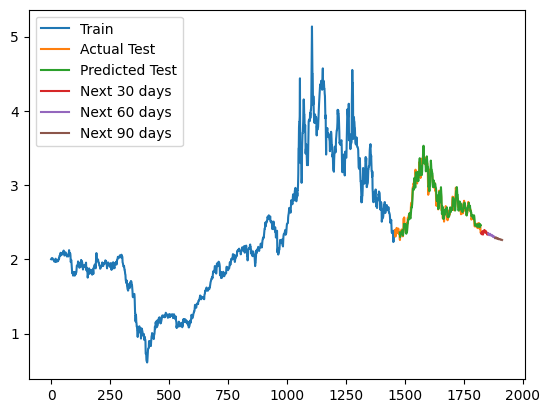

In [107]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()

## 9:1

In [108]:
df= pd.read_csv('../dataset/Heating Oil.csv')

In [109]:
keras.utils.set_random_seed(42)

### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [110]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [111]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010.0,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050.0,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160.0,0.1
...,...,...,...,...,...,...,...
1818,2024-05-24 00:00:00,2.4136,2.4175,2.4302,2.3897,21870.0,0.07
1819,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960.0,0.57
1820,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870.0,-1.14
1821,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120.0,-2.77


In [112]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010.0,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050.0,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160.0,0.1
...,...,...,...,...,...,...,...
1818,2024-05-24 00:00:00,2.4136,2.4175,2.4302,2.3897,21870.0,0.07
1819,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960.0,0.57
1820,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870.0,-1.14
1821,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120.0,-2.77


### Train, Test


In [113]:
# Split the data into training, testing, and validation sets
price = df['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Tạo và huấn luyện mô hình

In [114]:
X_train.shape

(1620, 20, 1)

In [115]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64)

c:\Users\21521\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1183  
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Ep

In [116]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [117]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 0.06304146222168698
MAPE trên tập test là: 1.8370377057228746 %
MDA trên tập test là: 44.72049689440994 %


In [118]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-20:]
next_90_days = []
for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print(next_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━

In [119]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)
next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1823,2.371557
1824,2.367002
1825,2.374190
1826,2.395138
1827,2.426314
...,...
1908,3.285825
1909,3.322473
1910,3.370981
1911,3.408925


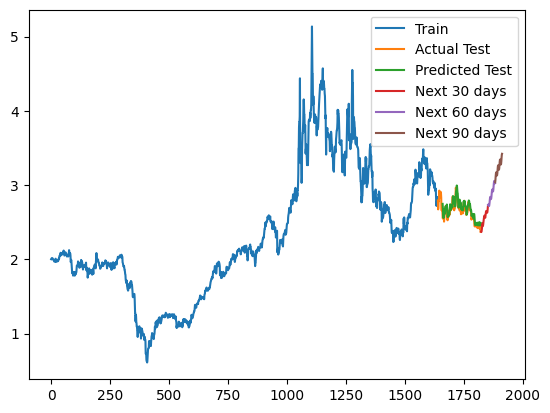

In [120]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()